In [51]:
import pandas as pd
import pandas_datareader.data as pdr
from datetime import date
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [52]:
yf.pdr_override()

In [53]:
tickers = ['GOOG','AMZN','MSFT','AAPL']
data_source = 'yahoo'

In [54]:
start_date = date(2020, 1, 1)
end_date = date(2023, 1, 1)

In [55]:
stock_prices = pdr.get_data_yahoo(tickers=tickers, start=start_date, end=end_date)
stock_prices = stock_prices.stack()

[*********************100%***********************]  4 of 4 completed


In [56]:
data = stock_prices['Close'].unstack()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 756 entries, 2020-01-02 to 2022-12-30
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    756 non-null    float64
 1   AMZN    756 non-null    float64
 2   GOOG    756 non-null    float64
 3   MSFT    756 non-null    float64
dtypes: float64(4)
memory usage: 29.5 KB


In [57]:
daily_returns = data.pct_change()
weights = np.array([0.05, 0.4, 0.3, 0.25])

In [58]:
# Calculate the covariance matrix on daily returns
# Note: 250 = 250 trading days in a year
cov_matrix = (daily_returns.cov())*250
print(cov_matrix)

          AAPL      AMZN      GOOG      MSFT
AAPL  0.135354  0.094914  0.091602  0.103363
AMZN  0.094914  0.151546  0.091062  0.094593
GOOG  0.091602  0.091062  0.117196  0.097821
MSFT  0.103363  0.094593  0.097821  0.119950


In [59]:
# Calculate the standard deviation by taking the square root
port_standard_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
print(str(np.round(port_standard_dev, 4) * 100) + '%')

32.74%


In [60]:
print(cov_matrix)

          AAPL      AMZN      GOOG      MSFT
AAPL  0.135354  0.094914  0.091602  0.103363
AMZN  0.094914  0.151546  0.091062  0.094593
GOOG  0.091602  0.091062  0.117196  0.097821
MSFT  0.103363  0.094593  0.097821  0.119950


## Comparing returns

1. *Annual Return*: Total return earned over a period of one calendar year
2. *Annualized return*: Yearly rate of return inferred from any time period
3. *Average Return*:  Total return realized over a longer period, spread out evenly over the (shorter) periods.
4. *Cumulative (compounding) return*: A return that includes the compounded results of re-investing, dividends, and capital gains.

### Calculating annualized returns

- **N in years**: rate = (1 + Return) ^ 1/N - 1
- **N in months**: rate = (1 + Return) ^ 12/N - 1
- Convert any time length to an annual rate
- **Return** is total return you want to annualize
- **N** is number of periods so far.

### Annualized returns in python

In [61]:
apple_price = data['AAPL']

apple_price.head(1)

Date
2020-01-02    75.087502
Name: AAPL, dtype: float64

In [62]:
apple_price.tail(1)

Date
2022-12-30    129.929993
Name: AAPL, dtype: float64

In [63]:
months = 24

In [64]:
# Calculate the total return
total_return = (apple_price[-1] - apple_price[0]) / apple_price[0]

print(total_return)

0.7303810892016547


In [65]:
annualized_return = ((1 + total_return)**(12/months)) - 1

print(annualized_return)

0.3154395041968501


In [66]:
for col in data.columns:
    total_return = (data[col].iloc[-1]  - data[col].iloc[0]) / data[col].iloc[0]
    annualized_return = ((1 + total_return)**(12/months)) -1
    print(col, annualized_return)

AAPL 0.3154395041968501
AMZN -0.059182474978833666
GOOG 0.13921901150546678
MSFT 0.2219203615755656


## Risk adjusted returns

### Choose a portfolio ?
**Portfolio 1**
- Annual return of 14%
- Volatility (standard deviation) is 8%

**Portfolio 2**
- Annual return of 6%
- Volatility is 3%

### About risk adjusted return
- It defines an investment's return by measuring how much risk is involved in producting that return
- It's usually a ratio
- Allows you to objectively compare across different investment options
- Tells you whether the return justifies the underlying risk

### Sharpe ratio
- Sharpe ratio is the most commonly used risk adjusted return ratio
- It's calculated as follows
- ***Sharpe ratio*** = (Rp - Rf) / Op
- Where: *Rp* is the portfolio return, *Rf* is the risk free rate and *Op* is the portfolio standard deviation
- ***Op*** = sqrt(Weights.T * (Covariance matrix * Weights))

### Annualizing volatility
- Annualized standard deviation is calculated as follows: Oa = Om * sqrt(T)
- Om is the measured standard deviation
- Oa is annualized standard deviation
- T is the number of data points per year (250)

### Calculating the Sharpe Ratio

In [67]:
apple_returns = apple_price.pct_change()

In [68]:
annualized_vol = apple_returns.std() * np.sqrt(250)
print(annualized_vol)

0.36790542445787827


In [69]:
risk_free = 0.01

In [70]:
total_return = (apple_price[-1]  - apple_price[0]) / apple_price[0]
annualized_return = ((1 + total_return)**(12/months)) - 1
print(annualized_return)

0.3154395041968501


In [71]:
sharpe_ratio = (annualized_return - risk_free) / annualized_vol
print(sharpe_ratio)

0.8302120161640074


## Non-normal distribution of returns

### Pearson's Coefficient of Skewness

***Skewness*** = 3 * (mean - median) / (standard deviation)

Rule of thumb:
- *Skewnesss* < -1 or *Skewness > 1 -> Highly skewed distribution
- -1 < *Skewness* < -0.5 or 0.5 < *Skewness* < 1 -> Moderately skewed distribution
- -0.5 < *Skewness* < 0.5 -> Approximately symmetric distribution

### Kurtosis: Fat tailed distribution
### Interpreting kurtosis
*"Higher kurtosis means more of the variance is the result of infrequent extreme deviations, as opposed to frequent modestly deviations"*

- A normal distribution has kurtosis of exactly 3 and is called (mesokurtic)
- A distribution with kurtosis <3 is called platykurtic. Tails are shorter and thinner, and central peak is lower and broader
- A distribution with kurtosis >3 is called leptokurtic. Tails are longer and fatter, and central peak is higher and sharper **(fat tailed)**

### Calculating skewness and kurtosis

In [72]:
apple_returns.head(3)

Date
2020-01-02         NaN
2020-01-03   -0.009722
2020-01-06    0.007968
Name: AAPL, dtype: float64

<Axes: >

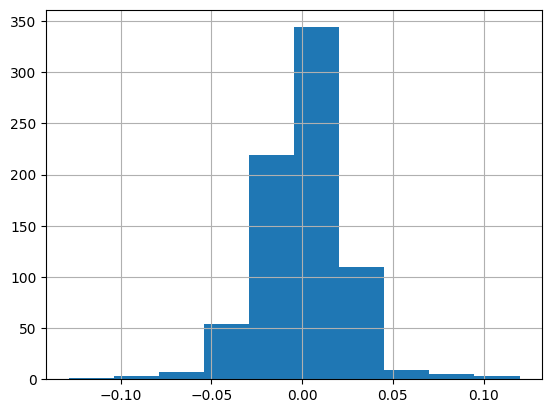

In [73]:
apple_returns.hist()

In [74]:
print("mean : ", apple_returns.mean())
print("vol : ", apple_returns.std())
print("skew : ", apple_returns.skew())
print("kurt : ", apple_returns.kurtosis())

mean :  0.0009966930451517286
vol :  0.023268382096358276
skew :  0.09752757534172643
kurt :  4.037640152069237
